In [33]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import scipy as sc
from scipy import stats
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score, precision_score,recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
import seaborn as sns
import numpy_indexed as npi

### Leer dataset

In [137]:
PATHDATA_MFFC_AVG = '../../data/audios_MFCC_average_5000.csv'
df = pd.read_csv(PATHDATA_MFFC_AVG, header = None)
data = df.values #Convertimos en un  numpy array

In [138]:
X = data[:,0:-3]
Y = data[:,-2]
print('Tamaño dataSet', X.shape)
print('\n')
Y=  np.reshape(Y,(np.size(Y,0),1))
groups = data[:,-1]
tracks = data[:,-3:-2]

Tamaño dataSet (5000, 20)




### Número de clases

In [139]:
n_classes=len(np.unique(Y))
print('Número de clases:', n_classes)

Número de clases: 5


### Número de hablantes

In [140]:
n_groups = len(np.unique(groups))
print('Número de hablantes diferentes', n_groups)

Número de hablantes diferentes 70


### Número de Audios

In [141]:
n_tracks = len(np.unique(tracks))
print('Número de audios diferentes',n_tracks)

Número de audios diferentes 500


## Dividir el dataset (train/test) 0.8/0.2

In [142]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
gss.get_n_splits()
for train_index, test_index in gss.split(X, Y, groups=groups):
    X_train_original, X_test__original = X[train_index], X[test_index]
    #print(X_train, X_test)
    Y_train__original, Y_test__original = Y[train_index], Y[test_index]
    #print(y_train, y_test)
    groups_original = groups[train_index]
    groups_test_original=groups[test_index]
    tracks_train_original = tracks[train_index]
    tracks_test_original = tracks[test_index]   

### Número de clases en test

In [143]:
n_classes_test=len(np.unique(Y_test__original))
print('Número de clases:', n_classes_test)

Número de clases: 5


In [144]:
groups_original.shape

(4120,)

In [145]:
X_train_original.shape

(4120, 20)

In [146]:
Y_train__original.shape

(4120, 1)

In [147]:
tracks_train_original.shape

(4120, 1)

In [148]:
FOLDS = 10
TRAIN_SIZE = 0.8

In [149]:
def build_model(model, parameters, folds, train_size, X,Y,groups_original):
    acc_scorer = make_scorer(accuracy_score)
    recalls = make_scorer(recall_score,average='micro')##buscar por que micro
    precision = make_scorer(precision_score,average='micro')
    f1 = make_scorer(f1_score,average='micro')
    scores =  {'recalls':recalls,'precision':precision,'f1':f1,'Accuracy': make_scorer(accuracy_score)}
    gss = GroupShuffleSplit(n_splits=folds, train_size=train_size, random_state=0)
    model = GridSearchCV(model,parameters,scores,-1,refit='Accuracy',return_train_score=True, cv=gss.split(X, Y, groups=groups_original))
    model.fit(X,Y)
    return model 

In [150]:
def Metrics(model,X_test,Y_test,tracks_test,clases):
    y_predicted = model.predict(X_test)
        
    y_predicted_with_tracks = np.column_stack((y_predicted,tracks_test))
    
    
    index_tracks = np.unique(tracks_test)    
    

    groups = npi.group_by(y_predicted_with_tracks[:,1])
    
    
    data_prediction_by_track = groups.split(y_predicted_with_tracks[:,0]) 
    
    
    mode_predict, count_predict = stats.mode(data_prediction_by_track,axis=1)
    
    
    #Clasificación real
    
    y_real_with_tracks = np.column_stack((Y_test,tracks_test))
    
    
    real_class = npi.group_by(y_real_with_tracks[:,1]).split(y_real_with_tracks[:,0])
    
    mode_real, count_real = stats.mode(real_class,axis=1)
    
  
    print('Accuracy: ', accuracy_score(mode_real, mode_predict), '\n')
    report = classification_report(mode_real, mode_predict)
    print("\nclassification report :\n",report )
     # Matriz de confusión
    cm = confusion_matrix(mode_real, mode_predict)
      # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))

    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=clases, yticklabels=clases)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax.set_ylim(sorted(ax.get_xlim(), reverse=True))
    plt.show(block=False)     

    return report

# GaussianMixture (GMM) 

## 1. Mejor modelo

Usamos X_train_original y Y_train__original para seleccionar la mejor combinación de parametros y posteriormente validar dichos resultados con el conjunto X_test__original y Y_test__original.

<b>Nota:</b> el conjunto X_train_original se divide en dos conjuntos train y dev a una proporción de 80 a 20.


In [151]:
parameters ={'n_components' : [2,3,4,5,6,7,8,9,10],'covariance_type': ['tied','full','spherical','diag']}
GMM =GaussianMixture()#Configurar el modelo
model_trained_gmm = build_model(GMM, parameters, FOLDS, TRAIN_SIZE, X_train_original,Y_train__original,groups_original)
best_params_gmm = model_trained_gmm.cv_results_['params'][model_trained_gmm.best_index_]
print(best_params_gmm)

{'covariance_type': 'diag', 'n_components': 5}


In [152]:
params_acurracy = ['mean_train_Accuracy','mean_test_Accuracy','std_train_Accuracy','std_test_Accuracy']
best_acurracy_gmm = []
for p in params_acurracy:
    parameter_acurracy =model_trained_gmm.cv_results_[p][model_trained_gmm.best_index_]
    best_acurracy_gmm.append({p:parameter_acurracy})
print("Resultados mejor modelo: ", best_params_gmm)
best_acurracy_gmm

Resultados mejor modelo:  {'covariance_type': 'diag', 'n_components': 5}


[{'mean_train_Accuracy': 0.21190305842358576},
 {'mean_test_Accuracy': 0.21371404992522539},
 {'std_train_Accuracy': 0.022066017407725878},
 {'std_test_Accuracy': 0.03331123379892407}]

## 2. Evalución mejor modelo con el conjunto de test

<b>Nota:</b> Usamos los conjuntos X_test__original y Y_test__original para evaluar el comportamiento del mejor modelo con datos

Accuracy:  0.18181818181818182 


classification report :
               precision    recall  f1-score   support

         0.0       0.06      0.09      0.07        11
         1.0       0.33      0.06      0.11        16
         2.0       0.15      0.15      0.15        20
         3.0       0.00      0.00      0.00        20
         4.0       0.23      0.52      0.32        21

    accuracy                           0.18        88
   macro avg       0.16      0.17      0.13        88
weighted avg       0.16      0.18      0.14        88



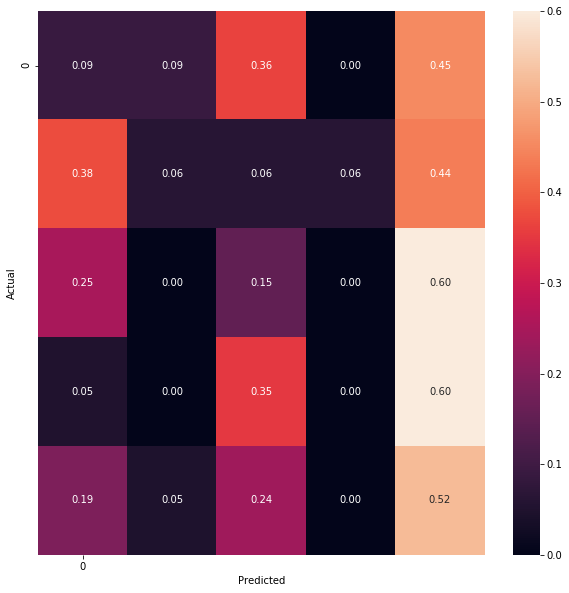

In [153]:
gmm_best_estimator = model_trained_gmm.best_estimator_
metrics = Metrics(gmm_best_estimator,X_test__original,Y_test__original,tracks_test_original,n_classes_test)